<a href="https://colab.research.google.com/github/TaeGongKim/tensorflow-developer/blob/main/Sequences%2C%20Time%20Series%20and%20Prediction/Predict_with_a_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

from IPython.display import display
from PIL import Image

2.6.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(False)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.1, np.cos(season_time * 6 * np.pi),
                  2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(10 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.005
noise_level = 3

In [4]:
series = baseline + trend(time, slope) + seasonality(time, period = 365,
                                                     amplitude = amplitude)
series += noise(time, noise_level, seed = 51)

In [5]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
!gdown --id 1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN

Downloading...
From: https://drive.google.com/uc?id=1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
To: /content/C4_W2_Assignment_Image.png
100% 18.5k/18.5k [00:00<00:00, 31.3MB/s]


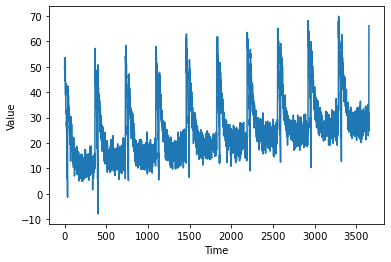

In [9]:
path='./C4_W2_Assignment_Image.png'
display(Image.open(path))

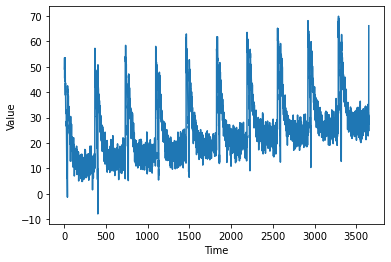

In [10]:
plot_series(time, series)

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [14]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(100, input_shape = [window_size], activation = 'relu'),
  tf.keras.layers.Dense(10, activation = 'relu'),
  tf.keras.layers.Dense(1)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9))
model.fit(dataset, epochs = 100, verbose = 1)

Epoch 1/100
94/94 [==============================] - 1s 4ms/step - loss: 90.7019
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 43.4339
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 35.8368
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 31.9372
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 29.9494
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 28.7107
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 27.9118
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 27.3300
Epoch 9/100
94/94 [==============================] - 0s 4ms/step - loss: 27.2131
Epoch 10/100
94/94 [==============================] - 0s 4ms/step - loss: 26.5456
Epoch 11/100
94/94 [==============================] - 0s 3ms/step - loss: 26.1492
Epoch 12/100
94/94 [==============================] - 0s 4ms/step - loss: 25.8570
Epoch 13/100
94/94 [=====

In [19]:
forcast = []
for time in range(len(series) - window_size):
  forcast.append(model.predict(series[time:time + window_size][np.newaxis]))

forcast = forcast[split_time - window_size:]
results = np.array(forcast)[:, 0, 0]

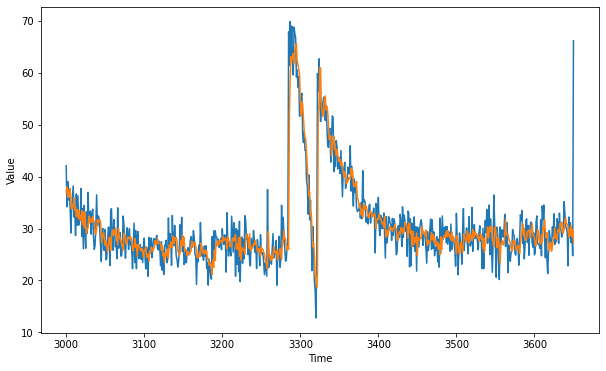

In [20]:
plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

2.9521034